# Cluster 17

In [1]:
import gizmo_analysis as gizmo
import utilities as ut
from matplotlib import pyplot as plt
import matplotlib
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from sl_utilities import distinct_colours as dc
from sl_utilities import distance_functions
import os
import pickle
from fof_analysis import fof

In /home1/07428/binod/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home1/07428/binod/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home1/07428/binod/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home1/07428/binod/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home1/07428/binod/anaconda3/lib/

In [2]:
!hostname
!pwd

c506-021.stampede2.tacc.utexas.edu
/home1/07428/binod


In [3]:
simname = 'm12i_res7100_mhdcv'
simdir = '/scratch/projects/xsede/GalaxiesOnFIRE/cr_suite/m12i_res7100/mhdcv/1Myr/fire2/'
simtype="fire2"
snapnumber=650
snap=snapnumber

#data_path="/home1/07428/binod/stampede_workfolder/fire2/fire2_data_pkl/" 
#gas_datapath="/home1/07428/binod/stampede_workfolder/fire2/fire2_gas_data_pkl/"

#gas_file_name=simtype+"_gas_data"+str(snapnumber)+".pkl"
#cluster_data_name="all_clusters_at_snapshot_"+str(snapnumber)+".pkl" 

#############################################################################
#constants
#############################################################################

MsunToGm = 1.99e33
KpcToCm = 3.086e21
mp = 1.67e-24
#bin_edge = 10.
bin_edge = 30.

bins = np.arange(-5,5,0.1)
#bins = np.arange(-25,25,0.1)


# Extracting age, location and metallicity information for the simulations

In [4]:
part=gizmo.io.Read.read_snapshots(['star'],'snapshot_index', snap, simulation_name=simname, simulation_directory=simdir, assign_hosts=True, assign_hosts_rotation=True)               #snap is the snapshot number here that changes everytime the loop iterates. It starts with sanpshot_start

age=part['star'].prop('age')
x=part['star'].prop('host.distance.principal')[:,0] #x component of the position of all stars 
y=part['star'].prop('host.distance.principal')[:,1] #y component of the position of all stars
z=part['star'].prop('host.distance.principal')[:,2] #z component of the position of all stars
Rxy = part['star'].prop('host.distance.principal.cylindrical')[:,0]
rxyz     = part['star'].prop('host.distance.total')
mass     = part['star'].prop('mass')

ids      = part['star'].prop('id')
id_child = part['star'].prop('id.child')
age      = part['star'].prop('age')

feh = part['star'].prop('metallicity.fe')
mgh = part['star'].prop('metallicity.mg')


# in utilities.simulation.Snapshot():
* reading:  scratch/projects/xsede/GalaxiesOnFIRE/cr_suite/m12i_res7100/mhdcv/1Myr/fire2/snapshot_times.txt

  using snapshot index = 650, redshift = 0.003


# in gizmo_analysis.gizmo_io.Read():
* reading header from:  scratch/projects/xsede/GalaxiesOnFIRE/cr_suite/m12i_res7100/mhdcv/1Myr/fire2/output/snapdir_650/snapshot_650.0.hdf5
  snapshot contains the following number of particles:
    dark      (id = 1): 70514272 particles
    dark2     (id = 2): 5513331 particles
    gas       (id = 0): 55645118 particles
    star      (id = 4): 15344402 particles
    blackhole (id = 5): 0 particles

* reading species: ['star']
* reading particles from:
    snapshot_650.0.hdf5
    snapshot_650.1.hdf5
    snapshot_650.2.hdf5
    snapshot_650.3.hdf5

* reading cosmological parameters from:  scratch/projects/xsede/GalaxiesOnFIRE/cr_suite/m12i_res7100/mhdcv/1Myr/fire2/initial_condition/ic_agora_m12i.conf

* checking sanity of particle properties
! warning: star

In [5]:
#select young stars within the disk for star clusters
keep = np.where((age <= .003) & ((Rxy < 20) & (Rxy>2)) & (abs(z) < 1.5))
#to run cluster finding on
rxyz0     = rxyz[keep]
Rxy0      = Rxy[keep]
x0        = x[keep]
y0        = y[keep]
z0        = z[keep]
mass0     = mass[keep]
feh0      = feh[keep]
mgh0      = mgh[keep]

id0       = ids[keep]
id_child0 = id_child[keep]
age0      = age[keep]

In [6]:
linking_length = 0.01 #10 parsec (unit here is in kpc)
ncut           = 10 #5 star particles
ind, xcm, ycm, zcm, mtot, grpid, r90, r50, rmax =fof.find(x0,y0,z0, b=linking_length, mass=mass0, ncut=ncut)
ngroup = len(mtot)

linking length  0.01
min number particles in group  10
0.06297612190246582 seconds
number of groups 6
max number in a group 26


# Loading cluster data and gas data

In [7]:
export_cluster={}
for grp_index in range(ngroup):  #iterate over each group
    cluster={}
    ids_in_cluster = id0[ind[grp_index]]  #these are the star particle ids in each cluster
    id_children_in_cluster = id_child0[ind[grp_index]]
    age_cluster=age0[ind[grp_index]]
    nstar = len(ids_in_cluster)
    groupid=grpid[grp_index]
    print('------------------------------------------------------------------------------------------------------------------')
    print('grpid, nstar, xcm (kpc), ycm (kpc), zcm (kpc), mtot (msun), rmax (pc)')
    print('%s     %i     %.4f     %.4f    %.4f     %.2e     %.1f ' % (grpid[grp_index], nstar, xcm[grp_index], ycm[grp_index], zcm[grp_index], mtot[grp_index], 1000*rmax[grp_index]))
    print("age of stars in the cluster",age_cluster)
    print('ids')
    string = '[' 
    for i in ids_in_cluster:
        string = string + str(i) + ', '

    #get rid of last extra ,
    length = len(string)-2
    string = string[0:length] + ']'
    print(string)

    print('id children')
    string = '[' 
    for i in id_children_in_cluster:
        string = string + str(i) + ', '

    #get rid of last extra ,
    length = len(string)-2
    string = string[0:length] + ']'
    print(string)
    print("These are the ids printed",ids_in_cluster)
    #feh_in_cluster=feh0[ind[grp_index]]
    #cluster={"cluster_groupid":groupid,"no_of_star":nstar,"id":ids_in_cluster,"id_children":id_children_in_cluster,"xcm":xcm[grp_index],"ycm":ycm[grp_index],"zcm":zcm[grp_index],"mtot":mtot[grp_index],"r90":r90[grp_index],"r50":r50[grp_index],"rmax":rmax[grp_index],"x":x0[ind[grp_index]],"y":y0[ind[grp_index]],"z":z0[ind[grp_index]],"age":age0[ind[grp_index]],"feh":feh0[ind[grp_index]],"mgh":mgh0[ind[grp_index]],"ch":ch0[ind[grp_index]],"nh":nh0[ind[grp_index]],"oh":oh0[ind[grp_index]],"neh":neh0[ind[grp_index]],"sih":sih0[ind[grp_index]],"sh":sh0[ind[grp_index]],"cah":cah0[ind[grp_index]],"mgfe":mgfe0[ind[grp_index]],"ofe":ofe0[ind[grp_index]],"sife":sife0[ind[grp_index]],"sfe":sfe0[ind[grp_index]],"cafe":cafe0[ind[grp_index]],"nefe":nefe0[ind[grp_index]]}
    cluster={"cluster_groupid":groupid,"no_of_star":nstar,"id":ids_in_cluster,"id_children":id_children_in_cluster,"xcm":xcm[grp_index],"ycm":ycm[grp_index],"zcm":zcm[grp_index],"mtot":mtot[grp_index],"r90":r90[grp_index],"r50":r50[grp_index],"rmax":rmax[grp_index],"x":x0[ind[grp_index]],"y":y0[ind[grp_index]],"z":z0[ind[grp_index]],"age":age0[ind[grp_index]],"feh":feh0[ind[grp_index]],"mgh":mgh0[ind[grp_index]]}

    export_cluster.update({groupid:cluster})


------------------------------------------------------------------------------------------------------------------
grpid, nstar, xcm (kpc), ycm (kpc), zcm (kpc), mtot (msun), rmax (pc)
1     26     -3.7395     -2.7974    0.0142     3.21e+05     25.8 
age of stars in the cluster [0.00146864 0.0015718  0.00148944 0.001551   0.0015302  0.00292374
 0.00099693 0.00235134 0.00212588 0.00095617 0.00099693 0.00239211
 0.00206431 0.00109926 0.00089461 0.00149942 0.00107929 0.00179725
 0.0027823  0.00112006 0.00089461 0.00112006 0.00112006 0.00093537
 0.00075069 0.00151523]
ids
[14058602, 34357020, 13147167, 5358915, 38684004, 65784341, 47370697, 39208166, 14111488, 29914784, 13481609, 10422086, 65263983, 34940154, 21311517, 24250014, 41504105, 31192369, 24381889, 25835958, 42077560, 18146433, 6783036, 57581487, 60526743, 41401080]
id children
[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
These are the ids printed [14058602 34357020 13147167  5358915 38684004 657

In [8]:
cluster_group=1
export_cluster[cluster_group].keys()

dict_keys(['cluster_groupid', 'no_of_star', 'id', 'id_children', 'xcm', 'ycm', 'zcm', 'mtot', 'r90', 'r50', 'rmax', 'x', 'y', 'z', 'age', 'feh', 'mgh'])

In [9]:
ind=export_cluster[1]["feh"]
print(feh)
print(export_cluster[1]["x"])
print(export_cluster[1]["r90"])


[-1.3928102  -3.8991706  -2.894322   ... -1.0909089  -0.32053772
 -1.1288569 ]
[-3.74805334 -3.75573017 -3.74389719 -3.75529638 -3.74321136 -3.7605802
 -3.73832077 -3.76425812 -3.75845405 -3.73877067 -3.73193215 -3.74166775
 -3.74597824 -3.72971874 -3.7301591  -3.73366287 -3.72612488 -3.74533911
 -3.7549103  -3.72659125 -3.72662605 -3.72477175 -3.72897631 -3.72762211
 -3.72865464 -3.73258108]
0.017659648284662866


# Locating the CM of the cluster

In [10]:
xcm=export_cluster[cluster_group]["xcm"]
ycm=export_cluster[cluster_group]["ycm"]
print("The cluster is located at:",(xcm,ycm))
radius=((xcm)**2+(ycm)**2)**(1/2)
print("The cluster CM is at radius: ",radius)

circle_radius=((x-xcm)**2+(y-ycm)**2)**(1/2)
print(len(circle_radius))

The cluster is located at: (-3.739526773080427, -2.797401371677934)
The cluster CM is at radius:  4.670065836886124
15344402


In [11]:
region=np.linspace(1,10,10)/10
print(region)


[0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]


The cluster CM is at radius:  4.670065836886124
[0.008358664, 0.0085517885, 0.009038214, 0.009522325, 0.009522325, 0.009522325, 0.009847507, 0.010267844, 0.011199509, 0.01131515]
The cluster CM is at radius:  12.841979748258208
[0.0038308667, 0.0037950592, 0.0062607112, 0.006162452, 0.006162452, 0.006162452, 0.006086651, 0.0059909765, 0.005947134, 0.00608873]
The cluster CM is at radius:  4.662889965744409
[0.008602954, 0.0085517885, 0.009038214, 0.009522325, 0.009522325, 0.009522325, 0.009522325, 0.010267844, 0.011232015, 0.01131515]
The cluster CM is at radius:  7.130996171849472
[0.014287248, 0.014897469, 0.014897469, 0.014762343, 0.014762343, 0.014762343, 0.014762343, 0.014762343, 0.014762343, 0.014762343]
The cluster CM is at radius:  6.921106382363384
[0.009435324, 0.009435324, 0.009167707, 0.009024805, 0.009024805, 0.009024805, 0.009024805, 0.009024805, 0.008595361, 0.008595361]
The cluster CM is at radius:  12.848461771277307
[0.0038308667, 0.0063133016, 0.0062607112, 0.0061624

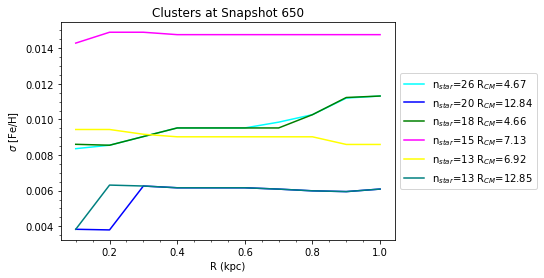

In [12]:
colors=['cyan','blue','green','magenta','yellow','teal','brown','darkslategray','lime','red','orange','purple','rosybrown','pink','navy','olive','cornflowerblue','blueviolet','darkgreen'] #19 colors
fig1=plt.figure()
ax=fig1.add_subplot(111)

for cluster_group in export_cluster:
    sigma_f=list()
    xcm=export_cluster[cluster_group]["xcm"]
    ycm=export_cluster[cluster_group]["ycm"]
    r90_cluster=export_cluster[cluster_group]["r90"]
    cluster_feh=export_cluster[cluster_group]["feh"]
    cluster_feh_sigma=np.std(cluster_feh)
    radius=((xcm)**2+(ycm)**2)**(1/2)
    print("The cluster CM is at radius: ",radius)
    circle_radius=((x-xcm)**2+(y-ycm)**2)**(1/2)
    for r in region:
        keep = np.where((age <= .003) & (circle_radius<=r) & (abs(z) < 1.5))
        feh_region=feh[keep]
        sigma_feh_region=np.std(feh_region)
        sigma_f.append(sigma_feh_region)

    print(sigma_f)
    nstar=len(export_cluster[cluster_group]["x"])
    label_text=r"n$_{star}$="+str(nstar)+r" R$_{CM}$="+str(round(radius,2))
    ax.plot(region,sigma_f,label=label_text,c=colors[cluster_group-1])
    #ax.scatter(r90_cluster,cluster_feh_sigma,marker="*",c=colors[cluster_group-1])

ax.set_xlabel("R (kpc)")
ax.set_ylabel(r"$\sigma$ [Fe/H]")
ax.minorticks_on()
ax.legend(bbox_to_anchor=(1,0.5), loc='center left')
ax.set_title("Clusters at Snapshot "+str(snapnumber))
fig1.savefig("sigma_feh_region_new_data.jpg",bbox_inches='tight',dpi=200)

# Mgh

The cluster CM is at radius:  4.670065836886124
The cluster CM is at radius:  12.841979748258208
The cluster CM is at radius:  4.662889965744409
The cluster CM is at radius:  7.130996171849472
The cluster CM is at radius:  6.921106382363384
The cluster CM is at radius:  12.848461771277307


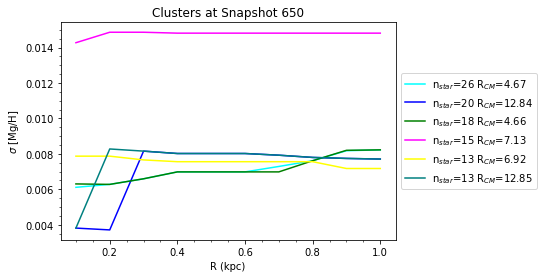

In [13]:
colors=['cyan','blue','green','magenta','yellow','teal','brown','darkslategray','lime','red','orange','purple','rosybrown','pink','navy','olive','cornflowerblue','blueviolet','darkgreen'] #19 colors
fig1=plt.figure()
ax=fig1.add_subplot(111)

for cluster_group in export_cluster:
    sigma_mgh=list()
    xcm=export_cluster[cluster_group]["xcm"]
    ycm=export_cluster[cluster_group]["ycm"]
    r90_cluster=export_cluster[cluster_group]["r90"]
    cluster_mgh=export_cluster[cluster_group]["mgh"]
    cluster_mgh_sigma=np.std(cluster_mgh)
    radius=((xcm)**2+(ycm)**2)**(1/2)
    print("The cluster CM is at radius: ",radius)
    circle_radius=((x-xcm)**2+(y-ycm)**2)**(1/2)
    for r in region:
        keep = np.where((age <= .003) & (circle_radius<=r) & (abs(z) < 1.5))
        mgh_region=mgh[keep]
        sigma_mgh_region=np.std(mgh_region)
        sigma_mgh.append(sigma_mgh_region)

    #print(sigma_mgh)
    nstar=len(export_cluster[cluster_group]["x"])
    label_text=r"n$_{star}$="+str(nstar)+r" R$_{CM}$="+str(round(radius,2))
    ax.plot(region,sigma_mgh,label=label_text,c=colors[cluster_group-1])
    #ax.scatter(r90_cluster,cluster_mgh_sigma,marker="*",c=colors[cluster_group-1])

ax.set_xlabel("R (kpc)")
ax.set_ylabel(r"$\sigma$ [Mg/H]")
ax.minorticks_on()
ax.legend(bbox_to_anchor=(1,0.5), loc='center left')
ax.set_title("Clusters at Snapshot "+str(snapnumber))
fig1.savefig(str(snapnumber)+"sigma_mgh_region_new_data.jpg",bbox_inches='tight',dpi=200)